# Chapter 4: Multilingual Named Entity Recognition

## On Fine-tuning ... to perform token classification (NER)

### General workflow

The workflow for the task of fine-tuning an existing model for token classfication can be broken down into for major tasks:

* preparing a dataset for fine-tuning
* preparing an appropriate head and configuration to use over the existing model
* prepare performance metrics, training arguments, and a data collator
* lastly, train your model and evaluate the results

#### Prepare dataset

1. Obtain a dataset.

1. Add any neccessary features to the dataset(s) required for token classification. In the case of NER and our dataset, the `ner_tags` feature have values that are `int` indicating the class. Since we would like to use the IOB2 format, we use `map()` and `ClassLabel.int2str()` to add another dataset feature containing the IOB2 tag strings corresponding to the `ner_tags` class `int` value.

1. Tokenize the training dataset according to your needs. _Make sure you have an appropriate tokenizer!_


#### Prepare custom model head that wraps an existing base model

1. Create a custom model for token classification. Ideally, this should wrap an existing base model and use the logits of that to classify the named entity tokens. In our case, we extend `transformers.models.roberta.modeling_roberta.RobertaPretrainedModel`, implementing `__init__` and `forward`.

1. Prepare a corresponding configuration object for our model. We can leverage [`transformer.AutoConfig.from_pretrained`](https://huggingface.co/docs/transformers/v4.26.1/en/model_doc/auto#transformers.AutoConfig.from_pretrained), passing in the model's name, the `num_labels` for the number of NER types (classes), and dictionaries mapping `id2label` and `label2id`.

1. Test this model and configuration on an example input.


#### Prepare for fine-tuning

1. Prepare performance metrics.

1. Prepare training arguments

1. Prepare data collator


#### Train and review metrics

1. Train

1. Review metrics

1. Perform error analysis

## The Dataset

... Check out the [xtreme](https://huggingface.co/datasets/xtreme) dataset on Huggingface.


In [1]:
from datasets import get_dataset_config_names, load_dataset

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [2]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

----

In [3]:
from collections import defaultdict
from datasets import DatasetDict

# the major languages in Switzerland!
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)

for lang,frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
                .shuffle(seed=0)
                .select(range(int(frac * ds[split].num_rows)))
        )

Found cached dataset xtreme (/home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ddf09f1ae095ec.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-25e7e2dd003d0fa6.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-73a95bc0accfea8b.arrow
Found cached dataset xtreme (/home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6ff29513007ec78b.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c5c9a4fc19dfd7d6.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9711ab25936b81b7.arrow
Found cached dataset xtreme (/home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-daa9a1770078307c.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5e244c05031bab3c.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-497ee15c12bff58d.arrow
Found cached dataset xtreme (/home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-757845faa9fa6949.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-305cefc7ffa49fd9.arrow
Loading cached shuffled indices for dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ec5e6ba7c1237d.arrow


In [4]:
import pandas as pd

pd.DataFrame(
    {lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
    index=["Number of training examples"]
)

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [5]:
print(panx_ch)

defaultdict(<class 'datasets.dataset_dict.DatasetDict'>, {'de': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
}), 'fr': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
}), 'it': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 1680
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 840
    })
    test: Dataset({
        features: ['token

In [6]:
element = panx_ch["de"]["train"][0]
print(type(element))
for key, value in element.items():
    print(f"{key}: {value}")

<class 'dict'>
tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [7]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [8]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [9]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [10]:
panx_de = panx_ch["de"].map(create_tag_names)

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-f46d0659f7a52a15.arrow
Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-333a88ffd23068c4.arrow
Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e6d4015812e9aa22.arrow


In [11]:
print(panx_de)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})


In [12]:
de_example = panx_de["train"][0]
pd.DataFrame(
    [de_example["tokens"], de_example["ner_tags_str"]],
    ["Tokens", "Tags"]
)

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [13]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(
    split2freqs,
    orient="index"
)

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Multilingual Transformers

XLM-Roberta supports 100 languages, Japanese included!

Suggested reading:

* [A. Conneau, K. Khandelwal, et al.; 2020; "Unsupervised Cross-lingual Representation Learning at Scale"](https://arxiv.org/pdf/1911.02116.pdf)
* [T. Kudo, J. Richardson; 2018; "SentencePiece: A Simple and Language Independent Subword Tokenizer and Detokenizer for Neural Text Processing"](https://arxiv.org/pdf/1808.06226.pdf)

----

## A Closer Look at Tokenization

In [14]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
text = "Jack Sparrow loves New York!"

In [16]:
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
print(f"BERT tokens: {bert_tokens}")
''.join(bert_tokens)

BERT tokens: ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']


'[CLS]JackSpa##rrowlovesNewYork![SEP]'

In [18]:
print(f"XML-R tokens: {xlmr_tokens}")
''.join(xlmr_tokens).replace(u'\u2581', ' ')

XML-R tokens: ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


'<s> Jack Sparrow loves New York!</s>'

Suggested reading:

* [J. Devlin, et al., "BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding"](https://arxiv.org/abs/1810.04805)

----

## Creating a Custom Model for Token Classification

Or, How to build a custom head for any task and just mount it on top of a pretrained model.

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [20]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        # load model body!
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        
        # set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        # load and initialize weights
        self.init_weights()


    def forward(
        self, 
        input_ids=None, 
        attention_mask=None, 
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        # use model body to get encoder representations
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        
        # apply classifier to encoding representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        
        # calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels),
                labels.view(-1)
            )
        
        # return
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

----

## Loading a Custom Model



In [21]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [22]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)

In [23]:
print(xlmr_config)

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'roberta

In [25]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

pd.DataFrame(
    [xlmr_tokens, input_ids[0].numpy()],
    index = ["Tokens", "Inputs IDs"]
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Inputs IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [26]:
outputs = xlmr_model(input_ids.to(device)).logits

predictions = torch.argmax(outputs, dim=2)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [27]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame(
    [xlmr_tokens, preds],
    index = ["Tokens", "Tags"]
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,I-PER,B-LOC,B-LOC,I-PER,B-LOC


In [28]:
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    
    # encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    
    # get prediction as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    
    # take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    
    # convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])
    

----

## Tokenizing Texts for NER

   `function(examples: Dict[str, List]) -> Dict[str, List]`

In [29]:
words, labels = de_example["tokens"], de_example["ner_tags"]

_what is `is_split_into_words`?_

In [30]:
tokenized_input = xlmr_tokenizer(
    de_example["tokens"], 
    is_split_into_words=True
)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


_what is `word_ids`?_

In [31]:
word_ids = tokenized_input.word_ids()

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [32]:
previous_word_index = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_index:
        label_ids.append(-100)
    elif word_idx != previous_word_index:
        label_ids.append(labels[word_idx])
    previous_word_index = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index  = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame(
    [tokens, word_ids, label_ids, labels],
    index = index
)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [33]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"],
        truncation = True,
        is_split_into_words = True
    )
    
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [34]:
def encode_panx_dataset(corpus):
    return corpus.map(
        tokenize_and_align_labels, 
        batched = True,
        remove_columns = [ "langs", "ner_tags", "tokens" ]
    )
                      

In [35]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9a0dfe82ca83754c.arrow
Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e21cd32e940e46a6.arrow
Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-eaf860e23239e210.arrow


In [36]:
print(panx_de_encoded)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})


----

## Performance Measures

`seqeval` ... is...?

Also see the [Metrics Card for `seqeval` on huggingface](https://huggingface.co/spaces/evaluate-metric/seqeval).

#### Regarding the `seqeval` output...

##### precision

... is...?

##### recall

... is...?

##### F1-score

... is...?

##### support

... is...?

##### micro average vs macro average vs weighted average

... see [this answer to the question "Micro Average vs Macro average Performance in a Multiclass classification setting" on the Data Science Stack Exchange](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)...

... and [another on macro average vs weighted average in `sklearn.metrics.classification_report`](https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report)



In [37]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



----

## Fine-tuning XLM-RoBERTa

### Create `TrainingArguments`

* Before instantiating your `Trainer`, create a `TrainingArguments` to access all the points of customization during training. In this example, our arguments encompass things like:
   * `output_dir` ... output directory where the model predictions and checkpoints will be written.
   * `log_level`
   * `num_train_epochs`
   * `per_device_train_batch_size`
   * `save_steps`
   * `logging_steps`
   <br/>... among other things... <p/>
* During training, if you do not take certain steps, you may see a warning message when invoking `trainer.train()`:

<pre>
/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
</pre>

To avoid this, try explicitly using the `adamw_torch` optimizer in your training arguments.

In [38]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    optim="adamw_torch",    # let's get rid of that annoying warning message
)

In [39]:
from huggingface_hub import notebook_login

# no error, means this call succeeded!
#
# you can click on the log entries icon in the lower
# left-hand portion of the window pane to see the
# logging messages indicating whether login
# succeeded or not
notebook_login()

----

### Create `transformers.Trainer`

In this example, we specify the following arguments when instantiating [`transformers.Trainer`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer):

##### `model_init` 
*  A function that instantiates the model to be used. If provided, each call to `train()` will start from a new instance of the model as given by this function.

##### `args` 
* define a `TrainingArguments` object instance that will contain all the hyperparameters the `Trainer` will use for training and evaluation.

##### `data_collator`
* The function to use to form a batch from a list of elements of train_dataset or eval_dataset. Will default to `default_data_collator(){ if no tokenizer is provided, an instance of DataCollatorWithPadding otherwise.

##### `compute_metrics`
* The function that will be used to compute metrics at evaluation. Must take a `EvalPrediction` and return a dictionary string to metric values.

##### `train_dataset`
* The dataset to use for training. If it is a `Dataset`, columns not accepted by the `model.forward()` method are automatically removed.

##### `eval_dataset`
* The dataset to use for evaluation. If it is a `Dataset`, columns not accepted by the `model.forward()` method are automatically removed. If it is a dictionary, it will evaluate on each dataset prepending the dictionary key to the metric name.

##### `tokenizer`
* The tokenizer used to preprocess the data. If provided, will be used to automatically pad the inputs to the maximum length when batching inputs, and it will be saved along the model to make it easier to rerun an interrupted training or reuse the fine-tuned model.


OK, let's get into the more important details of `Trainer`...

### `model_init`

An argument when creating an instance of the `Trainer` object itself, this helper function will let us instantiate new model instance with each call to `Trainer.train()`.

Here, note that we using the `from_pretrained` function in our custom `XLMRobertaForTokenClassification` class, passing in:
* `xlmr_model_name`
* `xlmr_config`

Note that we also put this newly-created model instance on the `device` (GPU), and then return a handle to that instance.

In [40]:
def model_init():
    return (
        XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device)
    )

### `compute_metrics`

A function called during training to calculate statistics.

This function must take an instance of [`EvalPrediction`](https://huggingface.co/docs/transformers/v4.26.1/en/internal/trainer_utils) as its sole argument, and then return a dictionary of string to metric values. This `EvalPrediction` argument has the following properties for use when calculating training statistics:
* `predictions` (`np.ndarray`) — Predictions of the model.
* `label_ids` (`np.ndarray`) — Targets to be matched.
* `inputs` (`np.ndarray`, optional) — 

In [41]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # ignore label IDS == -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list

In [42]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(
        eval_pred.predictions, 
        eval_pred.label_ids
    )
    return {"f1": f1_score(y_true, y_pred)}

### `data_collator`

* Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of `train_dataset` or `eval_dataset`.

* Here, we use an instance of [`transformers.DataCollatorForTokenClassification`](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/data_collator#transformers.DataCollatorForTokenClassification), passing in our `xlmr_tokenizer` tokenizer, which as `XLMRobertaTokenizerFast` is an subclass of [`transformers.PreTrainedTokenizerFast`](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast). This is a case of one of the advantages of leveraging huggingface's abstraction.

In [44]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

### blah

Instantiate `Trainer`, passing in all of our custom objects and data needed for fine-tuning.

In [45]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/the_oriental_love_ring/dev/github/transformers-gcp/xlm-roberta-base-finetuned-panx-de is already a clone of https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.258800,0.164123,0.814524
2,0.128800,0.139933,0.849726
3,0.080700,0.138362,0.863279


TrainOutput(global_step=1575, training_loss=0.15599132471614413, metrics={'train_runtime': 530.3003, 'train_samples_per_second': 71.167, 'train_steps_per_second': 2.97, 'total_flos': 863012377186080.0, 'train_loss': 0.15599132471614413, 'epoch': 3.0})

In [47]:
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de
   994258e..99b0744  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

'https://huggingface.co/buruzaemon/xlm-roberta-base-finetuned-panx-de/commit/99b0744da390a38aab6990ab7fce317e5cd64224'

In [48]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


----

## Error Analysis

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        
        # logit.size: [batch_size, sequence_length, classes]
        # predict class with larget logit vlaue on classes axis
        # don't forget to "bring" that value back to the CPU,
        # and convert to Numpy ???
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # calculate loss per token after flattening the batch dimension with view
    loss = cross_entropy(
        output.logits.view(-1, 7), # 7 NER types (classes)
        labels.view(-1),
        reduction="none"
    )
    
    # unflatten batch dimension, move computation back to CPU, and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss": loss, "predicted_label": predicted_label}

In [50]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()
#df

Parameter 'function'=<function forward_pass_with_label at 0x7f756d990a60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/the_oriental_love_ring/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1c80317fa3b1799d.arrow


In [51]:
index2tag[-100] = "IGN"

# add a new column for the input tokens
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)

# transform the column for predicted labels
# from label_id to actual label
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
 
# transform the column for actual labels
# from label_id to actual label
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)

# add a new column for showing loss
# per input_id in example x
df["loss"] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1
)

# transform the predicted_label column 
# to show the predicted label type 
# for each token in example x
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x['input_ids'])], axis=1
)

df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.011267012, 0.0, 0.03502869, 0.02726594...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [52]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.04,I-ORG,▁(
0,16104,1,I-ORG,0.03,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.03,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.76,B-ORG,▁Luz
1,10,1,I-ORG,0.45,I-ORG,▁a


In [53]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
        .agg(["count", "mean", "sum"])
        .droplevel(level=0, axis=1)    # get rid of multi-level columns
        .sort_values(by="sum", ascending=False)
        .reset_index()
        .round(2)
        .head(10)
        .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁von,▁der,▁/,▁und,▁(,▁'',▁),▁A
count,6066,989,808,1388,163,1171,246,2898,246,125
mean,0.04,0.13,0.16,0.09,0.58,0.07,0.28,0.02,0.27,0.44
sum,217.18,129.63,126.04,122.36,94.92,86.88,69.93,68.33,67.03,55.6


In [54]:
(
    df_tokens.groupby("labels")[["loss"]]
        .agg(["count", "mean", "sum"])
        .droplevel(level=0, axis=1)
        .sort_values(by="mean", ascending=False)
        .reset_index()
        .round(2)
        .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.64,0.6,0.48,0.33,0.28,0.18,0.03
sum,1712.62,874.23,1839.89,1058.45,797.83,728.21,1343.23


NOTE

2 errors in the code snippet listed on page 112:
* missing the `import matplotlib.pyplot as plt` bit
* order of `y_preds` and `y_true` reversed for `plot_confusion_matrix`?!

Corrected, it should be as follows below..

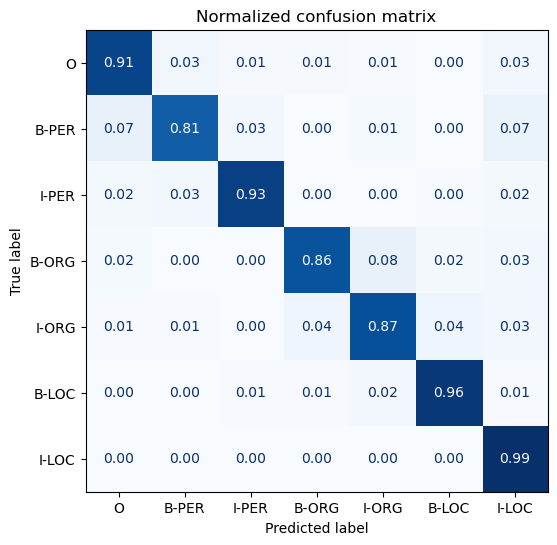

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(
    df_tokens["labels"],
    df_tokens["predicted_label"],
    tags.names
)

If this understanding is correct, we can reach these conclusions:

1. `B-PER` is most often mistaken for `O` at 0.07
1. `B-PER` is also often mistaken for `I-LOC` at 0.07
1. `B-ORG` is most often mistaken for `I-ORG` at 0.08